In [1]:
import random, numpy as np, torch
seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RUN_NAME = "filtered_ae_mse_vae_bs256_ep20_sr8k_T4000" # 更新 RUN_NAME 以反映更改

In [2]:
import sys
import os, glob, random, json
import numpy as np
import matplotlib.pyplot as plt
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # 用纯文本 tqdm，避免 ipywidgets warning


In [3]:
SAVE_DIR = "experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

cuda available: False


In [5]:

# from google.colab import drive
# drive.mount('/content/drive')
DATA_ROOT = r"C:\Users\11604\Desktop\thesis\hapticgen-dataset\expertvoted" 

def collect_clean_wavs(root):
    wavs = []
    for meta_path in glob.glob(os.path.join(root, "**/*.am1.json"), recursive=True):
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)

        # 用expertvoted里面的，这里目前全是initial
        if meta.get("model") == "HapticGen-Initial" and meta.get("vote") == 1:
            wav_path = os.path.join(os.path.dirname(meta_path), meta["filename"])
            if os.path.exists(wav_path):
                wavs.append(wav_path)

    return wavs

wav_files = collect_clean_wavs(DATA_ROOT)
print("Clean wavs:", len(wav_files))

assert len(wav_files) > 0, "没有筛选到任何 HapticGenInitial + vote=1 的 wav"


assert len(wav_files) > 0, "没找到任何 wav：请检查 DATA_ROOT 是否指向正确的根目录"

Clean wavs: 585


c:\Users\11604\anaconda3\envs\haptics-ae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Door_closed_with_large__bang__sound_EJ1LZ_4.wav
sr: 8000 len: 80000 min/max: -0.8515625 0.8203125


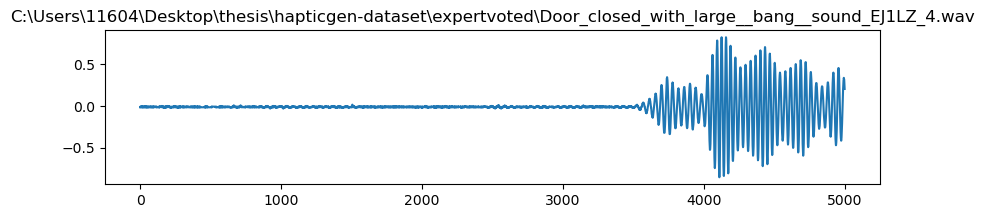


--- A_child_is_riding_a_squeaky_swing_in_the_playgroun_44GR0Q_3.wav
sr: 8000 len: 80000 min/max: -0.5546875 0.515625


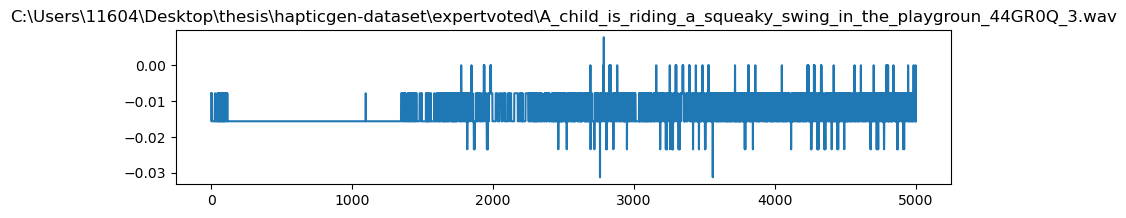


--- Me_crying_while_writing_a_paper_I_don_t_want_GEDIN_2.wav
sr: 8000 len: 80000 min/max: -0.265625 0.2421875


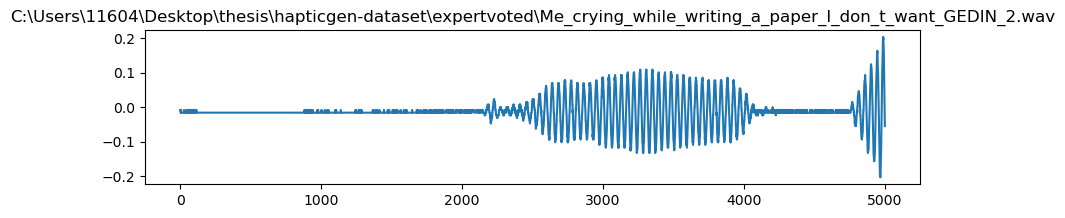

In [6]:
sample_wavs = random.sample(wav_files, 3)

for p in sample_wavs:
    y, sr = librosa.load(p, sr=None, mono=True)
    print("\n---", os.path.basename(p))
    print("sr:", sr, "len:", len(y), "min/max:", float(y.min()), float(y.max()))
    plt.figure(figsize=(10,2))
    plt.plot(y[:5000])
    plt.title(p)
    plt.show()


In [7]:
SR_EXPECT = 8000
T = 4000  # 0.5s @ 8kHz

USE_MINMAX = False  # ✅ 设为 False，禁用 min-max 归一化

def minmax_norm(seg):
    mn = seg.min()
    mx = seg.max()
    if mx - mn < 1e-8:
        return np.zeros_like(seg)
    return (seg - mn) / (mx - mn)   # [0,1]

def load_segment_energy(
    path, T=T, sr_expect=SR_EXPECT,
    tries=30, min_energy=5e-4, max_resample=5,
    fallback="best"   # "best" or "zeros"
):
    y, sr = librosa.load(path, sr=None, mono=True)
    if sr != sr_expect:
        y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)

    if len(y) < T:
        y = np.pad(y, (0, T - len(y)))

    max_start = len(y) - T  # >= 0

    best_seg_global = None
    best_energy_global = -1.0

    for _ in range(max_resample):
        best_seg = None
        best_energy = -1.0

        for _ in range(tries):
            start = np.random.randint(0, max_start + 1)
            seg = y[start:start+T]
            seg = seg - np.mean(seg)
            e = float(np.mean(seg**2))

            if e > best_energy:
                best_energy = e
                best_seg = seg

        # 记录全局最优（用于 fallback）
        if best_energy > best_energy_global:
            best_energy_global = best_energy
            best_seg_global = best_seg

        if best_energy >= min_energy:
            best_seg = best_seg_global  # 或 best_seg（两者此时一致/接近）
            break

    # ✅ 关键：不再 return None
    if best_seg_global is None:
        # 极端情况：文件读不到/空
        return np.zeros(T, dtype=np.float32)

    if best_energy_global < min_energy:
        if fallback == "zeros":
            return np.zeros(T, dtype=np.float32)
        # fallback == "best"：继续用能量最高的那段（即使低于门槛）

    # ===== 下面保持你原来的尺度归一化逻辑 =====
    SCALE = 0.25
    seg = best_seg_global / (GLOBAL_RMS + 1e-6)
    seg = seg * SCALE
    seg = np.clip(seg, -3.0, 3.0)

    if USE_MINMAX:
        seg = minmax_norm(seg)

    return seg.astype(np.float32)


In [8]:
N = len(wav_files)
perm = np.random.permutation(N)
train_idx = perm[:int(0.8 * N)]
val_idx   = perm[int(0.8 * N):]

train_files = [wav_files[i] for i in train_idx]
val_files   = [wav_files[i] for i in val_idx]

print("train:", len(train_files), "val:", len(val_files))

def estimate_global_rms(files, n=200, sr_expect=SR_EXPECT):
    picks = random.sample(files, min(n, len(files)))
    rms = []
    for p in picks:
        y, sr = librosa.load(p, sr=None, mono=True)
        if sr != sr_expect:
            y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)
        y = y - np.mean(y)
        rms.append(np.sqrt(np.mean(y**2)) + 1e-8)
    return float(np.median(rms))

GLOBAL_RMS = estimate_global_rms(train_files, n=200)
print("GLOBAL_RMS =", GLOBAL_RMS)

x = load_segment_energy(train_files[0], T=T)
print("seg std:", x.std(), "seg maxabs:", np.max(np.abs(x)))
x2 = load_segment_energy(train_files[1], T=T)
print("x2 is None?", x2 is None)
print("seg2 std:", np.std(x2), "seg2 maxabs:", np.max(np.abs(x2)))



class HapticWavDataset(Dataset):
    def __init__(self, files, T=4000):
        self.files = files
        self.T = T

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
    # 遇到 None（没找到足够能量的片段）就换文件重采样
        for _ in range(10):  # 最多尝试 10 次，避免死循环
          x = load_segment_energy(self.files[idx], T=self.T)
          if x is not None:
            return torch.from_numpy(x).unsqueeze(0)
          idx = np.random.randint(0, len(self.files))

    # 如果极端情况下 10 次都失败，返回全 0（保证类型正确）
        return torch.zeros(1, self.T, dtype=torch.float32)



batch_size = 32  # 减小batch size，让每个epoch有更多更新步骤
train_loader = DataLoader(HapticWavDataset(train_files, T=T), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(HapticWavDataset(val_files,   T=T), batch_size=batch_size, shuffle=False, drop_last=False)

# sanity check
xb = next(iter(train_loader))
print("batch shape:", xb.shape)  # (B, 1, T)


train: 468 val: 117
GLOBAL_RMS = 0.03723500669002533
seg std: 0.7092572 seg maxabs: 1.7018375
x2 is None? False
seg2 std: 1.4299536 seg2 maxabs: 3.0
batch shape: torch.Size([32, 1, 4000])


In [9]:
xb = next(iter(train_loader))  # (B,1,T)
stds = xb[:,0,:].numpy().std(axis=1)
print("silent-ish ratio:", (stds < 1e-3).mean())
print("std min/median/max:", stds.min(), np.median(stds), stds.max())


silent-ish ratio: 0.0
std min/median/max: 0.0053464994 0.45395756 2.659912


In [10]:
def GN(c):
    return nn.GroupNorm(num_groups=8, num_channels=c)

class ConvVAE(nn.Module):
    def __init__(self, T=4000, latent_dim=32, logvar_clip=(-10, 10)):
        super().__init__()
        self.T = T
        self.latent_dim = latent_dim
        self.logvar_clip = logvar_clip

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=25, stride=2, padding=12),
            GN(32), nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            GN(64), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=9, stride=2, padding=4),
            GN(128), nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, kernel_size=9, stride=2, padding=4),
            GN(128), nn.LeakyReLU(0.2),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, T)
            h = self.encoder(dummy)
            self.enc_shape = h.shape[1:]
            self.enc_feat = h.numel()

        self.fc_mu     = nn.Linear(self.enc_feat, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_feat, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, self.enc_feat)

        # 使用 xavier 初始化，不要用零初始化权重
        nn.init.xavier_uniform_(self.fc_mu.weight)
        nn.init.zeros_(self.fc_mu.bias)
        nn.init.xavier_uniform_(self.fc_logvar.weight)
        nn.init.constant_(self.fc_logvar.bias, -1.0)  # 初始化为较小的方差

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 128, kernel_size=9, stride=2, padding=4, output_padding=1),
            GN(128), nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=2, padding=4, output_padding=1),
            GN(64), nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1),
            GN(32), nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(32, 1, kernel_size=9, stride=2, padding=4, output_padding=1),
        )

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, self.logvar_clip[0], self.logvar_clip[1])
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, logvar

    def forward(self, x):
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)

        mu = self.fc_mu(h_flat)
        logvar_raw = self.fc_logvar(h_flat)
        z, logvar = self.reparameterize(mu, logvar_raw)

        h2 = self.fc_dec(z).view(x.size(0), *self.enc_shape)
        x_hat = self.decoder(h2)

        T = x.shape[-1]
        if x_hat.shape[-1] > T:
            x_hat = x_hat[..., :T]
        elif x_hat.shape[-1] < T:
            x_hat = torch.nn.functional.pad(x_hat, (0, T - x_hat.shape[-1]))

        return x_hat, mu, logvar, z


In [ ]:
ckpt_path = f"{SAVE_DIR}/ckpt_{RUN_NAME}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

latent_dim = 64  # 增大潜在维度，32000:64 = 500:1 压缩比更合理
model = ConvVAE(T=T, latent_dim=latent_dim).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)  # 降低weight_decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=15)  # 增大patience，防止lr衰减太快

def spectral_loss(x_hat, x):
    """频谱损失：比较重建信号和原始信号的频谱"""
    x_fft = torch.fft.rfft(x)
    x_hat_fft = torch.fft.rfft(x_hat)
    return torch.mean(torch.abs(x_fft - x_hat_fft))

def relative_mse(x_hat, x, eps=1e-6):
    """相对误差：对不同幅度的信号更公平"""
    # 按样本计算缩放因子
    scale = torch.abs(x).mean(dim=-1, keepdim=True) + eps
    return torch.mean(((x_hat - x) / scale) ** 2)

def kl_divergence_free_bits(mu, logvar, free_bits=0.1):
    """
    Free-bits KL: 每个维度至少允许 free_bits nats 的信息
    防止后验坍塌
    """
    # 每个维度的 KL
    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())  # (B, latent_dim)
    # 对每个维度应用 free_bits 门槛
    kl_per_dim = torch.clamp(kl_per_dim, min=free_bits)
    # 对维度求和，对 batch 求平均
    return kl_per_dim.sum(dim=1).mean()


def cyclical_beta_schedule(epoch, total_epochs, n_cycles=4, ratio=0.5, beta_max=0.0001):
    """
    Cyclical annealing: beta 周期性从 0 上升到 beta_max
    - n_cycles: 周期数
    - ratio: 每个周期中上升阶段的比例
    """
    cycle_length = total_epochs / n_cycles
    cycle_pos = epoch % cycle_length
    
    if cycle_pos / cycle_length < ratio:
        # 上升阶段
        return beta_max * (cycle_pos / (cycle_length * ratio))
    else:
        # 保持阶段
        return beta_max


total_epochs = 100  # 增加训练轮数
print_every = 10  # 每10个epoch打印一次
patience = 15  # 增大 patience，因为 cyclical annealing 会导致 loss 波动
min_delta = 1e-4

train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
wait = 0


device: cpu
ConvVAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(2,), padding=(12,))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv1d(64, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): GroupNorm(8, 128, eps=1e-05, affine=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv1d(128, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (10): GroupNorm(8, 128, eps=1e-05, affine=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=32000, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=32000, out_features=64, bias=True)
  (fc_dec): Linear(in_features=64, out_features=32000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 128, kernel_size=(9,), stride=(2,), padding=(4,), outpu

In [12]:
print("train batches:", len(train_loader), "val batches:", len(val_loader))
print("train size:", len(train_loader.dataset), "val size:", len(val_loader.dataset))
print("one val batch shape:", next(iter(val_loader)).shape)



train batches: 14 val batches: 4
train size: 468 val size: 117
one val batch shape: torch.Size([32, 1, 4000])


In [13]:

def run_epoch(loader, train=True, epoch=1):
    model.train(train)
    total_loss = 0.0
    count = 0

    mode = "train" if train else "val"
    if len(loader) == 0:
        raise ValueError("val_loader is empty (len==0). Check your val split / DataLoader.")

    pbar = tqdm(loader, leave=False, desc=f"{mode} epoch {epoch}")

    for batch_idx, x in enumerate(pbar):
        x = x.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        x_hat_raw, mu, logvar, z = model(x)
        if batch_idx == 0:
          print(f"RAW x_hat stats [{mode.upper()}]:",
          "min =", x_hat_raw.detach().min().item(),
          "max =", x_hat_raw.detach().max().item(),
          "mean =", x_hat_raw.detach().mean().item(),
          "std =", x_hat_raw.detach().std().item())

        x_hat = torch.clamp(x_hat_raw, -3.0, 3.0)  # 简单 clamp 到输入范围

        mse = torch.nn.functional.mse_loss(x_hat, x)
        l1  = torch.nn.functional.l1_loss(x_hat, x)
        spec = multi_scale_spectral_loss(x_hat, x)
        recon = mse + 0.2 * l1 + 0.1 * spec  # 多尺度频谱损失，保留音频细节

        # 使用 free-bits KL 防止后验坍塌
        kl = kl_divergence_free_bits(mu, logvar, free_bits=0.1)
        
        # 使用 cyclical annealing
        beta = cyclical_beta_schedule(epoch, total_epochs, n_cycles=4, ratio=0.5, beta_max=0.0001)
        
        # VAE 损失 = 重建损失 + beta * KL散度
        loss = recon + beta * kl


        # ✅ 只在非有限时跳过
        if not torch.isfinite(loss):
            print("⚠️ non-finite loss, skip batch",
                  "recon=", recon.detach().item(),
                  "kl=", kl.detach().item(),
                  "beta=", beta,
                  "logvar min/max=", logvar.detach().min().item(), logvar.detach().max().item())
            continue

        # ✅ debug：只打印每个 epoch 的第一个 batch
        if batch_idx == 0:
            print(f"DEBUG {mode.upper()}:",
                  "x min/max", x.detach().min().item(), x.detach().max().item(),
                  "| x_hat min/max", x_hat.detach().min().item(), x_hat.detach().max().item(),
                  "| recon", recon.detach().item(),
                  "| kl", kl.detach().item(),
                  "| beta", beta)
            print("mu abs mean:", mu.detach().abs().mean().item(),
                  "logvar min/max:", logvar.detach().min().item(), logvar.detach().max().item())

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        bs = x.shape[0]
        total_loss += loss.detach().item() * bs
        count += bs

        pbar.set_postfix(loss=f"{(total_loss/max(count,1)):.4f}",
                         recon=f"{recon.detach().item():.4f}",
                         kl=f"{kl.detach().item():.4f}",
                         beta=f"{beta:.1e}")

    return total_loss / max(count, 1)


# ========= training loop + early stopping =========
early_stop_start = 10   # ✅ 前10个epoch不early stop（建议）
best_val = float("inf") # 确保初始化正确
wait = 0

for epoch in range(1, total_epochs + 1):
    tr = run_epoch(train_loader, train=True,  epoch=epoch)
    va = run_epoch(val_loader,   train=False, epoch=epoch)

    train_losses.append(tr)
    val_losses.append(va)

    # ✅ scheduler 只在 va 有效时 step
    if np.isfinite(va):
        scheduler.step(va)
    lr = optimizer.param_groups[0]["lr"]

    if epoch % print_every == 0 or epoch == 1:
        overall = 100.0 * epoch / total_epochs
        print(f"[Epoch {epoch:03d}/{total_epochs} | overall {overall:5.1f}%] "
              f"lr={lr:.2e} | train={tr:.6f} | val={va:.6f}")

    # ✅ early stopping（warmup 后才启用）
    if epoch >= early_stop_start:
        if (not np.isfinite(va)):
            wait += 1
        elif va < best_val - min_delta:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
            torch.save(best_state, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best val = {best_val:.6f}")
                break

print("✅ Best val:", best_val)
print("✅ Saved best model weights to:", ckpt_path)

# ========= load best =========
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()


train epoch 1:   0%|          | 0/14 [00:00<?, ?it/s]

RAW x_hat stats [TRAIN]: min = -4.879335880279541 max = 8.693735122680664 mean = 1.18193519115448 std = 1.7185840606689453
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 12.245523452758789 | kl 59.152008056640625 | beta 8.000000000000001e-06
mu abs mean: 0.9013989567756653 logvar min/max: -4.484943866729736 2.085069179534912


val epoch 1:  50%|█████     | 2/4 [00:00<00:00,  7.77it/s, beta=8.0e-06, kl=5481.3066, loss=2.7604, recon=3.3236]    

RAW x_hat stats [VAL]: min = -0.49627459049224854 max = 1.0009677410125732 mean = -0.019444264471530914 std = 0.13730119168758392
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.49627459049224854 1.0009677410125732 | recon 2.1104555130004883 | kl 5373.88623046875 | beta 8.000000000000001e-06
mu abs mean: 10.849967002868652 logvar min/max: -10.0 -3.8955624103546143


[Epoch 001/100 | overall   1.0%] lr=2.00e-04 | train=6.267796 | val=2.793228


train epoch 2:   0%|          | 0/14 [00:00<?, ?it/s]

RAW x_hat stats [TRAIN]: min = -0.5384847521781921 max = 0.9497084617614746 mean = -0.019481433555483818 std = 0.137054443359375
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.5384847521781921 0.9497084617614746 | recon 3.65678071975708 | kl 5788.9755859375 | beta 1.6000000000000003e-05
mu abs mean: 11.303680419921875 logvar min/max: -10.0 -5.406247615814209


val epoch 2:  50%|█████     | 2/4 [00:00<00:00,  7.73it/s, beta=1.6e-05, kl=1330.8203, loss=2.0806, recon=2.6705]    

RAW x_hat stats [VAL]: min = -0.21973803639411926 max = 0.1978629231452942 mean = -0.00785859301686287 std = 0.04982536658644676
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.21973803639411926 0.1978629231452942 | recon 1.4483366012573242 | kl 1313.515380859375 | beta 1.6000000000000003e-05
mu abs mean: 4.848526954650879 logvar min/max: -10.0 -3.4745917320251465


train epoch 3:   7%|▋         | 1/14 [00:00<00:03,  3.54it/s, beta=2.4e-05, kl=1304.9751, loss=2.9843, recon=2.9530]

RAW x_hat stats [TRAIN]: min = -0.2580004930496216 max = 0.20832860469818115 mean = -0.007922512479126453 std = 0.0505795031785965
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.2580004930496216 0.20832860469818115 | recon 2.953028440475464 | kl 1304.97509765625 | beta 2.4e-05
mu abs mean: 4.836455345153809 logvar min/max: -10.0 -3.401610851287842


val epoch 3:  50%|█████     | 2/4 [00:00<00:00,  7.71it/s, beta=2.4e-05, kl=1056.2389, loss=2.3260, recon=3.0566]    

RAW x_hat stats [VAL]: min = -0.12183975428342819 max = 0.11918342858552933 mean = -0.004540987778455019 std = 0.025937799364328384
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.12183975428342819 0.11918342858552933 | recon 1.5449707508087158 | kl 1043.552001953125 | beta 2.4e-05
mu abs mean: 4.252781391143799 logvar min/max: -10.0 -3.6079587936401367


train epoch 4:   7%|▋         | 1/14 [00:00<00:03,  3.56it/s, beta=3.2e-05, kl=1094.0953, loss=3.3650, recon=3.3300]

RAW x_hat stats [TRAIN]: min = -0.1025271937251091 max = 0.1085188165307045 mean = -0.0045732297003269196 std = 0.025557147338986397
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.1025271937251091 0.1085188165307045 | recon 3.330036163330078 | kl 1094.0953369140625 | beta 3.2000000000000005e-05
mu abs mean: 4.373115539550781 logvar min/max: -10.0 -3.9889919757843018


val epoch 4:  50%|█████     | 2/4 [00:00<00:00,  7.22it/s, beta=3.2e-05, kl=662.8323, loss=2.2816, recon=2.9379]    

RAW x_hat stats [VAL]: min = -0.10021747648715973 max = 0.1067621260881424 mean = 0.0020821476355195045 std = 0.022662486881017685
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.10021747648715973 0.1067621260881424 | recon 1.5831375122070312 | kl 658.8034057617188 | beta 3.2000000000000005e-05
mu abs mean: 3.1731491088867188 logvar min/max: -10.0 -3.9135520458221436


train epoch 5:   0%|          | 0/14 [00:00<?, ?it/s, beta=4.0e-05, kl=669.8273, loss=3.5281, recon=3.5013]     

RAW x_hat stats [TRAIN]: min = -0.10531538724899292 max = 0.10382823646068573 mean = 0.0020658113062381744 std = 0.02256673201918602
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.10531538724899292 0.10382823646068573 | recon 3.501303195953369 | kl 669.8273315429688 | beta 4e-05
mu abs mean: 3.2029852867126465 logvar min/max: -10.0 -3.9020652770996094


val epoch 5:  50%|█████     | 2/4 [00:00<00:00,  7.54it/s, beta=4.0e-05, kl=512.0093, loss=2.2794, recon=3.0881]    

RAW x_hat stats [VAL]: min = -0.10154487192630768 max = 0.09586559981107712 mean = -0.0102933868765831 std = 0.022135132923722267
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.10154487192630768 0.09586559981107712 | recon 1.4294908046722412 | kl 518.7948608398438 | beta 4e-05
mu abs mean: 2.6549324989318848 logvar min/max: -10.0 -4.943110466003418


train epoch 6:   7%|▋         | 1/14 [00:00<00:03,  3.28it/s, beta=4.8e-05, kl=512.6304, loss=2.4558, recon=2.4312]

RAW x_hat stats [TRAIN]: min = -0.10543148219585419 max = 0.07974199205636978 mean = -0.010319087654352188 std = 0.02220015972852707
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.10543148219585419 0.07974199205636978 | recon 2.43123197555542 | kl 512.63037109375 | beta 4.8e-05
mu abs mean: 2.633080005645752 logvar min/max: -10.0 -4.70750617980957


val epoch 6:  50%|█████     | 2/4 [00:00<00:00,  7.36it/s, beta=4.8e-05, kl=433.5507, loss=2.1895, recon=2.9160]    

RAW x_hat stats [VAL]: min = -0.07978272438049316 max = 0.11278139054775238 mean = 0.006880191620439291 std = 0.022854961454868317
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.07978272438049316 0.11278139054775238 | recon 1.4210312366485596 | kl 439.7894592285156 | beta 4.8e-05
mu abs mean: 2.407832622528076 logvar min/max: -10.0 -4.598405838012695


train epoch 7:   0%|          | 0/14 [00:00<?, ?it/s, beta=5.6e-05, kl=437.4773, loss=1.8239, recon=1.7994]     

RAW x_hat stats [TRAIN]: min = -0.08771109580993652 max = 0.09383045136928558 mean = 0.006880306638777256 std = 0.02288372442126274
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.08771109580993652 0.09383045136928558 | recon 1.7993866205215454 | kl 437.477294921875 | beta 5.6000000000000006e-05
mu abs mean: 2.39650559425354 logvar min/max: -10.0 -4.545937538146973


KeyboardInterrupt: 

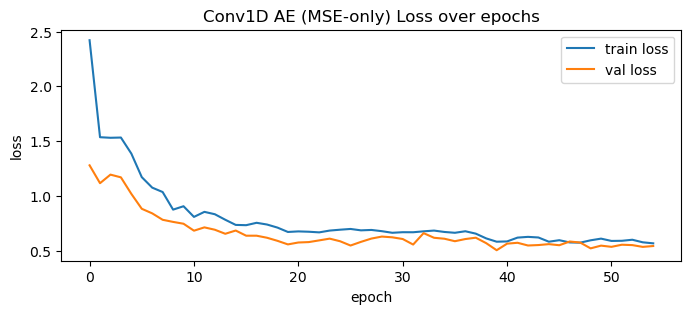

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.title("Conv1D AE (MSE-only) Loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


C:\Users\11604\AppData\Local\Temp\ipykernel_39852\2770215104.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

mu mean/std: 0.025453591719269753 1.8264186382293701
logvar mean: -7.865455627441406
0 orig max 1.8662895 recon max 1.7115777
1 orig max 1.5984141 recon max 1.6500751
2 orig max 3.0 recon max 4.613332


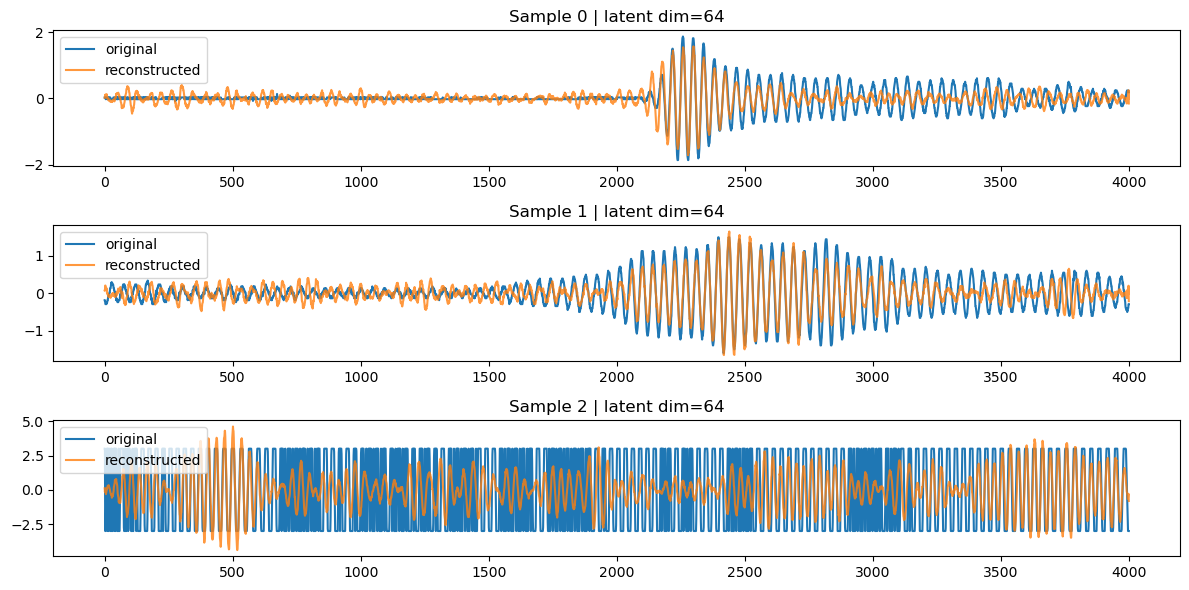

Example latent z[0]: [-1.1066589  -1.6996849  -1.4940625   0.844108   -1.430541    0.43336967
 -4.0198617   2.0300503  -0.25755984  0.13123253 -3.2074008  -1.6996722
 -1.9379449  -0.18490124 -2.0248451   1.2554091   0.10130908 -2.4431562
  0.00416681 -1.3272623  -3.9006758   2.791535    1.1835788  -1.5276171
  2.3443856  -1.2845163  -0.9581991  -2.6506398   2.03433    -0.3642741
 -2.4763517  -3.5301766   1.4436988  -0.3813237   1.4944559   1.506491
  1.8165258   0.59027576 -1.3952463  -0.6283949  -1.663732    1.076541
 -0.3661517   0.19717374  0.71967685 -0.13210124  0.6486346  -0.69110596
  2.6279087  -1.176299    0.07555441  0.36318615 -0.3633148   0.903951
  0.5074705   0.35230947 -0.64951396  2.908192    2.164622   -1.7978989
  0.6375736  -1.6860558   2.1596537  -0.13359627]


In [ ]:
# 从 val 里拿一批
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

x = next(iter(val_loader))[:3].to(device)  # (3,1,T)

with torch.no_grad():
    x_hat, mu, logvar, z = model(x)
print("mu mean/std:", mu.mean().item(), mu.std().item())
print("logvar mean:", logvar.mean().item())

x_np = x[:,0,:].cpu().numpy()
xhat_np = x_hat[:,0,:].cpu().numpy()

plt.figure(figsize=(12,6))
for i in range(3):
    print(i, "orig max", np.max(np.abs(x_np[i])), "recon max", np.max(np.abs(xhat_np[i])))
    plt.subplot(3,1,i+1)
    plt.plot(x_np[i], label="original")
    plt.plot(xhat_np[i], label="reconstructed", alpha=0.8)
    plt.title(f"Sample {i} | latent dim={latent_dim}")
    plt.legend()
plt.tight_layout()
plt.show()

print("Example latent z[0]:", z[0].cpu().numpy())


In [ ]:
import numpy as np
from IPython.display import Audio, display

sr = SR_EXPECT  # 8000

def prep(w):
    w = w.astype(np.float32)

    # 如果在 [0,1]，映射回 [-1,1]
    if w.min() >= 0 and w.max() <= 1.0:
        w = w * 2.0 - 1.0

    m = np.max(np.abs(w)) + 1e-8
    w = w / m
    return np.clip(w, -1.0, 1.0)


i = 1  # 选第几个样本（0/1/2）

orig = prep(x_np[i])
recon = prep(xhat_np[i])

print("Original:")
display(Audio(orig, rate=sr))

print("Reconstruction:")
display(Audio(recon, rate=sr))

# 拼成一个：原声 -> 0.2s 静音 -> 重建（更方便听差异）
silence = np.zeros(int(0.2 * sr), dtype=np.float32)
ab = np.concatenate([orig, silence, recon])
print("A/B combined:")
display(Audio(ab, rate=sr))


Original:


Reconstruction:


A/B combined:


In [ ]:
# import soundfile as sf

# sf.write(f"{SAVE_DIR}/orig_{RUN_NAME}.wav", orig, sr)
# sf.write(f"{SAVE_DIR}/recon_{RUN_NAME}.wav", recon, sr)
# sf.write(f"{SAVE_DIR}/AB_{RUN_NAME}.wav", ab, sr)

In [ ]:
print("Quantitative Assessment of Reconstruction Quality (Standard Deviation):")
for i in range(3):
    orig_std = np.std(x_np[i])
    recon_std = np.std(xhat_np[i])
    print(f"Sample {i}: Original STD = {orig_std:.4f}, Reconstructed STD = {recon_std:.4f}")


Quantitative Assessment of Reconstruction Quality (Standard Deviation):
Sample 0: Original STD = 0.3859, Reconstructed STD = 0.2834
Sample 1: Original STD = 0.4938, Reconstructed STD = 0.3764
Sample 2: Original STD = 2.6640, Reconstructed STD = 2.0681


In [ ]:
# ============================================================
# 重建 10 个样本并播放音频 (Original vs Reconstructed vs A/B)
# ============================================================
import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import torch

NUM_SAMPLES = 10
sr = SR_EXPECT  # 8000

# ---------- 收集足够多的样本 ----------
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

all_x, all_xhat = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        x_hat, mu, logvar, z = model(batch)
        all_x.append(batch[:, 0, :].cpu().numpy())
        all_xhat.append(x_hat[:, 0, :].cpu().numpy())
        if sum(a.shape[0] for a in all_x) >= NUM_SAMPLES:
            break

all_x = np.concatenate(all_x, axis=0)[:NUM_SAMPLES]
all_xhat = np.concatenate(all_xhat, axis=0)[:NUM_SAMPLES]

print(f"共重建 {NUM_SAMPLES} 个样本\n")

# ---------- prep 函数（含可选去噪） ----------
from scipy.signal import savgol_filter

def prep(w, denoise=False):
    w = w.astype(np.float32)
    if w.min() >= 0 and w.max() <= 1.0:
        w = w * 2.0 - 1.0
    if denoise:
        # 轻度 Savitzky-Golay 平滑，去除高频噪声但保留信号特征
        w = savgol_filter(w, window_length=7, polyorder=3)
    m = np.max(np.abs(w)) + 1e-8
    w = w / m
    return np.clip(w, -1.0, 1.0).astype(np.float32)

# ---------- 逐个可视化 + 播放音频 ----------
for idx in range(NUM_SAMPLES):
    orig = prep(all_x[idx])
    recon = prep(all_xhat[idx])
    recon_smooth = prep(all_xhat[idx], denoise=True)  # 去噪版

    orig_max = np.max(np.abs(all_x[idx]))
    recon_max = np.max(np.abs(all_xhat[idx]))
    orig_std = np.std(all_x[idx])
    recon_std = np.std(all_xhat[idx])
    std_ratio = recon_std / (orig_std + 1e-8) * 100

    print("=" * 70)
    print(f"Sample {idx}  |  orig max={orig_max:.4f}  recon max={recon_max:.4f}  |  STD: {orig_std:.4f} → {recon_std:.4f} ({std_ratio:.0f}%)")
    print("=" * 70)

    # --- 波形对比图 ---
    plt.figure(figsize=(14, 3))
    plt.plot(all_x[idx], label="original", linewidth=0.6, alpha=0.7)
    plt.plot(all_xhat[idx], label="reconstructed", alpha=0.7, linewidth=0.6)
    plt.title(f"Sample {idx} | latent_dim={latent_dim} | STD ratio={std_ratio:.0f}%")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 播放音频 ---
    print("  ▶ Original:")
    display(Audio(orig, rate=sr))

    print("  ▶ Reconstructed:")
    display(Audio(recon, rate=sr))

    silence = np.zeros(int(0.2 * sr), dtype=np.float32)
    ab = np.concatenate([orig, silence, recon])
    print("  ▶ A/B (original → silence → reconstructed):")
    display(Audio(ab, rate=sr))
    print()